In [301]:
import numpy as np
import matplotlib.pyplot as plt

In [302]:
rates = np.array([3.2e6, 24, 290, 0.5]) # intrinsic rates for reactions: 1. polymerization of GTP-bound monomers, 2. depolymerization of GTP-bound monomers, 3. depolymerization of GDP-bound monomers, 4. hydrolysis of GTP
concentration = 11e-6 # concentration of monomers in the solution
ratio = 0.01 # ratio of rate of polymerization of GDP-bound monomers to rate of polymerization of GTP-bound monomers

In [303]:
def update_propensities(propensities, filament, concentration, ratio, rates=rates):
    '''
    Function to update the propensities of the reactions depending on the state of the filament.

    Args:
        propensities: (np.array) Array with the propensities of the reactions.
        filament: (list) List of the states of the monomers in the filament.
        concentration: (float) Concentration of tubulin.
        rates: (np.array) Array with the intrinsic rates of the reactions.
        ratio: (float) Ratio between the rates of polymerization of GDP-bound and GTP-bound monomers.

    Returns:
        propensities: (np.array) Array with the updated propensities of the reactions.
    '''

    # calculate the number of GTP bound tubulin
    n_gtp = sum(filament)

    k_gtpPolymerization = rates[0] * concentration
    k_gdpPolymerization = k_gtpPolymerization * ratio
    k_gtpDepolymerization = rates[1]
    k_gdpDepolymerization = rates[2]
    k_hydrolysis = rates[3]*n_gtp

    if filament[-1] == 1: # if the last monomer is GTP bound
        propensities[0] = k_gtpPolymerization
        propensities[1] = k_gtpDepolymerization
    else: # if the last monomer is GDP bound
        propensities[0] = k_gdpPolymerization
        propensities[1] = k_gdpDepolymerization

    propensities[2] = k_hydrolysis

    return propensities

In [304]:
def sample_discrete(propensities):
    '''
    Function to sample the next reaction to occur.

    Args:
        propensities: (np.array) Array with the propensities of the reactions.

    Returns:
        index: (int) Index of the reaction that occurs.
        0. Polymerization
        1. Depolymerization
        2. Hydrolysis
    '''

    # calculate the total propensity
    total_propensity = sum(propensities)

    # sample a random number
    r = np.random.rand()

    # calculate the cumulative sum of the propensities
    cum_sum = np.cumsum(propensities)

    # find the index of the reaction that occurs
    index = np.searchsorted(cum_sum, r*total_propensity)

    return index

In [305]:
def gillespie_draw(propensity_func, propensities, filament, *args):
    '''
    Function to draw the next time and reaction to occur.

    Args:
        propensity_func: (function) Function to update the propensities of the reactions.
        propensities: (np.array) Array with the propensities of the reactions.
        filament: (list) List of the states of the monomers in the filament.
        *args: Additional arguments for the propensity function.

    Returns:
        tau: (float) Time until the next reaction occurs.
        index: (int) Index of the reaction that occurs.
    '''

    # update the propensities
    propensities = propensity_func(propensities, filament, *args)

    # calculate the total propensity
    total_propensity = sum(propensities)

    # sample the time until the next reaction occurs
    tau = np.random.exponential(1.0/total_propensity)

    # sample the reaction that occurs
    index = sample_discrete(propensities)

    return tau, index

In [310]:
def gillespie(t_max, concentration, ratio):
    '''
    Function to run the simulation of the Gillespie algorithm.

    Args:
        t_max: (float) Maximum time of the simulation.
        concentration: (float) Concentration of tubulin.
        ratio: (float) Ratio between the rates of polymerization of GDP-bound and GTP-bound monomers

    Returns:
        t: (list) List with the times of the simulation.
        len: (list) List with the length of the filament at each time.
    '''

    # initialization
    t = [0.0]
    filament = [1]*10
    l_t = [len(filament)]
    propensities = np.array([0, 0, 0])

    # run the simulation
    while t[-1] < t_max:
        tau, index = gillespie_draw(update_propensities, propensities, filament, concentration, ratio)
        t.append(t[-1] + tau)

        if index == 0: # polymerization
            filament.append(1)
        elif index == 1: # depolymerization
            filament.pop()
        else: # hydrolysis of a GTP-bound monomer
            gtp_monomers = [i for i, x in enumerate(filament) if x == 1]
            i = np.random.choice(gtp_monomers)
            filament[i] = 0

        l_t.append(len(filament))

        if len(filament) == 1:
            break

    return t, l_t

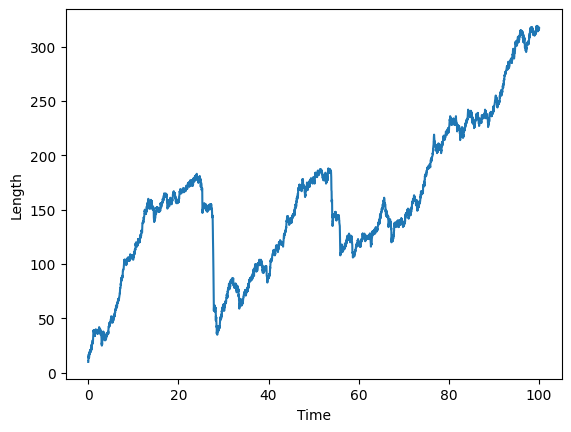

In [324]:
t, l_t = gillespie(100, concentration=9.4e-6, ratio=1)

plt.plot(t, l_t)
plt.xlabel('Time')
plt.ylabel('Length')

plt.show()